**Importing Necessary Libraries**

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, f1_score)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

**Logistic Regression - Unbalanced Dataset**

In [4]:
# 1. Load and prepare data
df = pd.read_csv(r'../Preprocessing/Unbalanced_Multiclass.csv')  # Your balanced dataset

In [5]:
df['target'].value_counts()

target
8     367
3      80
14     27
2      16
1      15
0      15
7       7
13      6
9       4
11      2
4       1
5       1
10      1
6       1
12      1
Name: count, dtype: int64

In [6]:
X = df.drop('target', axis=1)
y = df['target']

In [8]:
# 2. Split data (stratified for class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42
)

In [9]:
# 3. Feature scaling (essential for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# 4. Initialize and train Logistic Regression model
log_reg = LogisticRegression(
    solver='lbfgs',       
    max_iter=1000,        
    class_weight='balanced', 
    random_state=42,
    n_jobs=-1              
)

In [11]:
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1,
                   random_state=42)

In [12]:
# 5. Predictions
y_pred = log_reg.predict(X_test_scaled)
y_proba = log_reg.predict_proba(X_test_scaled)  # For probability outputs

**Logistic Regression - Balanced Dataset**

In [ ]:
# 1. Load and prepare data
df = pd.read_csv(r'D:\Bicycle_Lock\Machine-Learning\ECG-Based Arrhythmia Detection\Preprocessing\balanced_ecg_data.csv')  # Your balanced dataset

In [11]:
df['target'].value_counts()

target
8     367
3     367
13    367
2     367
4     367
5     367
14    367
6     367
10    367
1     367
11    367
7     367
0     367
12    367
9     367
Name: count, dtype: int64

In [12]:
X = df.drop('target', axis=1)
y = df['target']

In [13]:
# 2. Split data (stratified for class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42,
    stratify=y  # Preserve class distribution
)

In [14]:
# 3. Feature scaling (essential for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         4
           2       0.50      0.57      0.53         7
           3       0.71      0.75      0.73        20
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         2
           8       0.99      0.85      0.92       115
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.90      0.75      0.82        12

    accuracy                           0.77       164
   macro avg       0.24      0.22      0.23       164
weighted avg       0.87      0.77      0.81       164


Confusion Matrix:


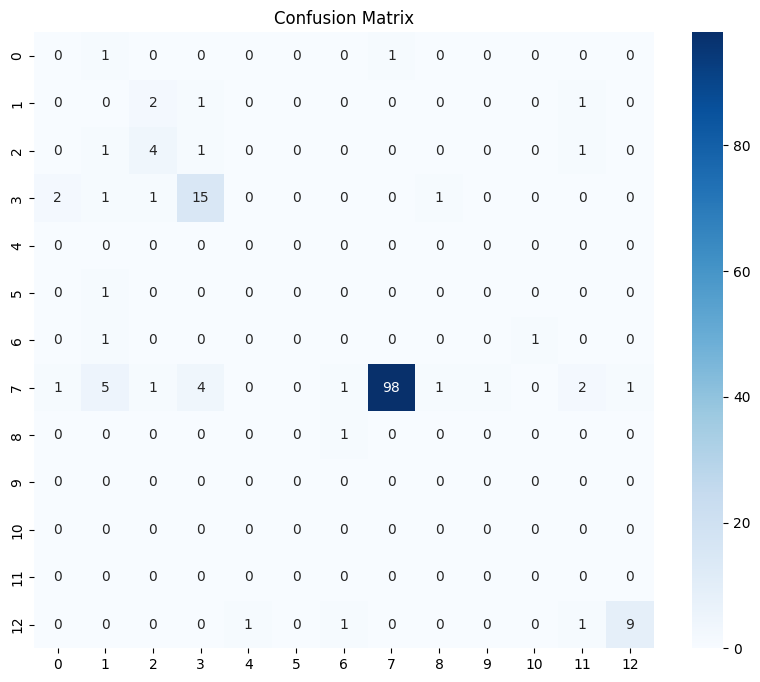

In [14]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

Overall Accuracy: 0.7683 (76.83%)


**Logistic Regression - SKLearn Library**

In [15]:
# 4. Initialize and train Logistic Regression model
log_reg = LogisticRegression(
    solver='lbfgs',       # Optimizer
    max_iter=1000,        # Ensure convergence
    class_weight='balanced', # Handles class imbalance
    random_state=42,
    n_jobs=-1              # Use all CPU cores
)

In [16]:
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1,
                   random_state=42)

In [17]:
# 5. Predictions
y_pred = log_reg.predict(X_test_scaled)
y_proba = log_reg.predict_proba(X_test_scaled)  # For probability outputs

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       110
           1       0.98      1.00      0.99       110
           2       0.98      0.95      0.97       110
           3       0.92      0.94      0.93       111
           4       1.00      1.00      1.00       110
           5       1.00      1.00      1.00       110
           6       1.00      1.00      1.00       111
           7       0.99      1.00      1.00       110
           8       0.99      0.91      0.95       110
           9       0.99      1.00      1.00       110
          10       1.00      1.00      1.00       110
          11       0.99      1.00      1.00       110
          12       1.00      1.00      1.00       110
          13       0.98      1.00      0.99       110
          14       1.00      1.00      1.00       110

    accuracy                           0.99      1652
   macro avg       0.99      0.99      0.99      1652
wei

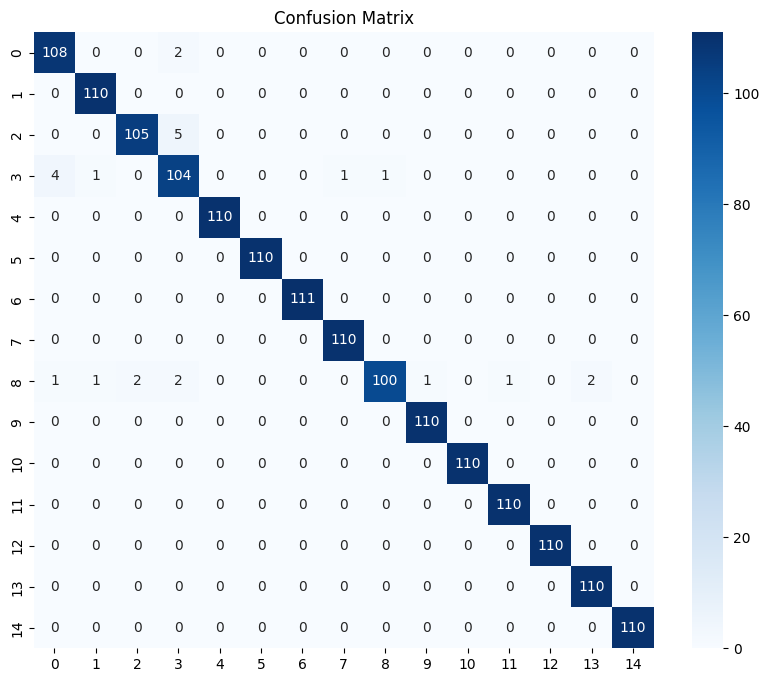

In [18]:
# 6. Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

print("\nConfusion Matrix:")
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [7]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

Overall Accuracy: 0.9855 (98.55%)
